<a href="https://colab.research.google.com/github/owemecoffee/ai-learn/blob/main/CNN_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for Pneumonia Detection
This notebook explores the common methods used in pneumonia detection, and provides with related detailed tips. 


---


 **todos:**


1.   don't redo things
2.   should i rebalance N-P images. If use GAN, how to import? 
3.   identify bone pos to reduce violent crop 
4.   use pytorch to design model
---

**questions**

1.   is cropping to same size a must?
2.   filter in tf ?
3.   callback in tf?
4.   explore more on image: segmentation, heatmap...

## Import Dataset from Kaggle
 refer to a [CXR tutorial](https://colab.research.google.com/github/fadheladlansyah/chest-xray-pneumonia/blob/master/eda.ipynb#scrollTo=5x3P-39I3Kbc)

In [2]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop

import requests
from io import BytesIO

import json
import zipfile

from random import sample
from datetime import datetime
from tqdm import tqdm, auto
import shutil
import os
import gc
import warnings
warnings.filterwarnings("ignore")

In [3]:
# install Kaggle library
!pip list
!pip install -q kaggle

Package                       Version
----------------------------- ------------------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.4
branca                        0.5.0
bs4                           0.

In [4]:
# upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [9]:
# !mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
# download dataset <owner>/<dataset-name>
!kaggle datasets download paultimothymooney/chest-xray-pneumonia --force

100% 2.29G/2.29G [00:14<00:00, 146MB/s]
100% 2.29G/2.29G [00:14<00:00, 170MB/s]


In [11]:
#unzip and copy path

with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zf:
  zf.extractall()

img_dir = os.path.join(os.getcwd(), 'chest_xray')
test_img_dir = os.path.join(img_dir, 'test')
train_img_dir = os.path.join(img_dir, 'train')
val_img_dir = os.path.join(img_dir, 'val')

## Check on Dataset

Total   5856  samples.
Total   5216 train samples.
Total   16 validation samples.
Total   624 test samples.


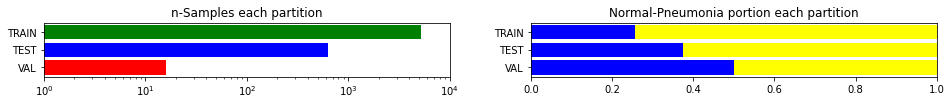

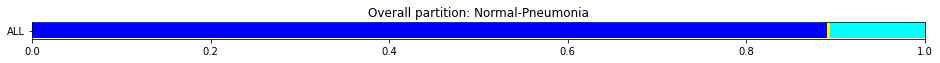

In [12]:
#@title Normal-Pneumonia partition { display-mode: "form" }
NB_TRAIN_SAMPLES_N = len(os.listdir(os.path.join(train_img_dir, 'NORMAL')))
NB_TRAIN_SAMPLES_P = len(os.listdir(os.path.join(train_img_dir, 'PNEUMONIA')))
NB_TRAIN_SAMPLES = NB_TRAIN_SAMPLES_N + NB_TRAIN_SAMPLES_P

NB_VAL_SAMPLES_N = len(os.listdir(os.path.join(val_img_dir, 'NORMAL')))
NB_VAL_SAMPLES_P = len(os.listdir(os.path.join(val_img_dir, 'PNEUMONIA')))
NB_VAL_SAMPLES = NB_VAL_SAMPLES_N + NB_VAL_SAMPLES_P

NB_TEST_SAMPLES_N = len(os.listdir(os.path.join(test_img_dir, 'NORMAL')))
NB_TEST_SAMPLES_P = len(os.listdir(os.path.join(test_img_dir, 'PNEUMONIA')))
NB_TEST_SAMPLES = NB_TEST_SAMPLES_N + NB_TEST_SAMPLES_P

NB_TOTAL_SAMPLES = NB_TRAIN_SAMPLES + NB_VAL_SAMPLES + NB_TEST_SAMPLES

#basic situation
print("Total  ",NB_TOTAL_SAMPLES," samples.")
print("Total  ",NB_TRAIN_SAMPLES,"train samples.")
print("Total  ",NB_VAL_SAMPLES,"validation samples.")
print("Total  ",NB_TEST_SAMPLES,"test samples.")


#visualize
def chart_partitioning():

  fig = plt.figure(figsize=(16,1))

  ax = fig.add_subplot(1,2,1)
  ax.barh(['VAL'], [NB_VAL_SAMPLES], color='red')
  ax.barh(['TEST'], [NB_TEST_SAMPLES], color='blue')
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES], color='green')
  ax.set_xscale('log')
  ax.set_xlim((1,1e4))
  ax.set_title('n-Samples each partition');

  ax = fig.add_subplot(1,2,2)
  ax.barh(['VAL'], [NB_VAL_SAMPLES_N/NB_VAL_SAMPLES], color='#0000ff')
  ax.barh(['VAL'], [NB_VAL_SAMPLES_P/NB_VAL_SAMPLES], color='#ffff00',
          left=[NB_VAL_SAMPLES_N/NB_VAL_SAMPLES])
  ax.barh(['TEST'], [NB_TEST_SAMPLES_N/NB_TEST_SAMPLES], color='#0000ff')
  ax.barh(['TEST'], [NB_TEST_SAMPLES_P/NB_TEST_SAMPLES], color='#ffff00', 
          left=[NB_TEST_SAMPLES_N/NB_TEST_SAMPLES])
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES], color='#0000ff')
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_P/NB_TRAIN_SAMPLES], color='#ffff00', 
          left=[NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES])
  ax.set_xlim((0,1))
  ax.set_title('Normal-Pneumonia portion each partition');

  fig = plt.figure(figsize=(16,0.3))
  ax = fig.add_subplot(1,1,1)
  NB_TOTAL_SAMPLES = NB_TEST_SAMPLES + NB_TRAIN_SAMPLES + NB_VAL_SAMPLES
  ax.barh(['ALL'], [NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES], color='#0000ff')
  ax.barh(['ALL'], [NB_VAL_SAMPLES/NB_TOTAL_SAMPLES], color='#ffff00',
          left=[NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES])
  ax.barh(['ALL'], [NB_TEST_SAMPLES/NB_TOTAL_SAMPLES], color='#00ffff',
          left=[(NB_TRAIN_SAMPLES+NB_VAL_SAMPLES)/NB_TOTAL_SAMPLES])
  ax.set_xlim((0,1))
  ax.set_title('Overall partition: Normal-Pneumonia');

chart_partitioning()

### Rebalance Dataset


*   Validation set too small(16 images) and caused high oscilation in the training process. 
*   Try ~80%, ~10%, ~10% by moving some train samples to val.




In [13]:
# count how many samples to move so that train partition ~80%
train_part = NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES
n_to_move = round((train_part - 0.8) * NB_TRAIN_SAMPLES)

print("Should move ", n_to_move, "images out.")

Should move  473 images out.


In [14]:
# count each n and p samples to move
# later train val have the same N/P proportion
n_to_move_N = round((NB_TRAIN_SAMPLES_N + NB_VAL_SAMPLES_N) /
                    (NB_TRAIN_SAMPLES + NB_VAL_SAMPLES) * n_to_move)
n_to_move_P = n_to_move - n_to_move_N

print("Should move ", n_to_move_N, "normal images out.")
print("Should move ", n_to_move_P,"pneumonia images out.")

Should move  122 normal images out.
Should move  351 pneumonia images out.


In [15]:
# move rendom files from one directory to other directory
def move_files_random(from_dir, to_dir, n):
  for filename in sample(os.listdir(from_dir), k=n):
    from_fpath = os.path.join(from_dir, filename)
    to_fpath = os.path.join(to_dir, filename)
    shutil.move(from_fpath, to_fpath)
  display(f"move {n} files from {from_dir} to {to_dir}")

move_files_random(from_dir=os.path.join(train_img_dir, 'NORMAL'),
                  to_dir=os.path.join(val_img_dir, 'NORMAL'),
                  n=n_to_move_N)

move_files_random(from_dir=os.path.join(train_img_dir, 'PNEUMONIA'),
                  to_dir=os.path.join(val_img_dir, 'PNEUMONIA'),
                  n=n_to_move_P)

'move 122 files from /content/chest_xray/train/NORMAL to /content/chest_xray/val/NORMAL'

'move 351 files from /content/chest_xray/train/PNEUMONIA to /content/chest_xray/val/PNEUMONIA'

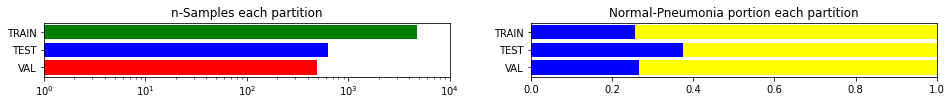

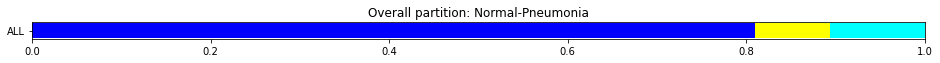

In [16]:
##@title Samples partition after restructure { display-mode: "form" }

NB_TRAIN_SAMPLES_N = len(os.listdir(os.path.join(train_img_dir, 'NORMAL')))
NB_TRAIN_SAMPLES_P = len(os.listdir(os.path.join(train_img_dir, 'PNEUMONIA')))
NB_TRAIN_SAMPLES = NB_TRAIN_SAMPLES_N + NB_TRAIN_SAMPLES_P

NB_VAL_SAMPLES_N = len(os.listdir(os.path.join(val_img_dir, 'NORMAL')))
NB_VAL_SAMPLES_P = len(os.listdir(os.path.join(val_img_dir, 'PNEUMONIA')))
NB_VAL_SAMPLES = NB_VAL_SAMPLES_N + NB_VAL_SAMPLES_P

NB_TEST_SAMPLES_N = len(os.listdir(os.path.join(test_img_dir, 'NORMAL')))
NB_TEST_SAMPLES_P = len(os.listdir(os.path.join(test_img_dir, 'PNEUMONIA')))
NB_TEST_SAMPLES = NB_TEST_SAMPLES_N + NB_TEST_SAMPLES_P

NB_TOTAL_SAMPLES = NB_TRAIN_SAMPLES + NB_VAL_SAMPLES + NB_TEST_SAMPLES

chart_partitioning()

### plot some images

## Preprocessing

In [17]:
#@title set epoch, batch_size {display-mode:"form"}

EPOCHS = 22 #@param {type:"slider", min:5, max:100, step:1}
BATCH_SIZE = 100 #@param {type:"slider", min:10,max:200}

### data augmentation


*   chop images to same size
why generator different ?

In [18]:
IMG_WIDTH, IMG_HEIGHT = 150, 150

gen_hard = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 8,
    zoom_range = 0.1,
    width_shift_range = 0.08,
    height_shift_range = 0.08,
    horizontal_flip = False,
    vertical_flip = False,
    shear_range = 0.02
  )

train_generator = gen_hard.flow_from_directory(
    train_img_dir,
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'binary'
)

gen_simple = ImageDataGenerator(
    rescale = 1./255,
  )

val_generator = gen_simple.flow_from_directory(
                                val_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=BATCH_SIZE,
                                class_mode='binary',
                                )

test_generator = gen_simple.flow_from_directory(
                                test_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=32,
                                shuffle=False,
                                class_mode='binary',
                                )

Found 4743 images belonging to 2 classes.
Found 489 images belonging to 2 classes.
Found 624 images belonging to 2 classes.




*   note that chop might cause imcomplete chest feature in images
*   flow_n for crop size, idx_n for vertical index 



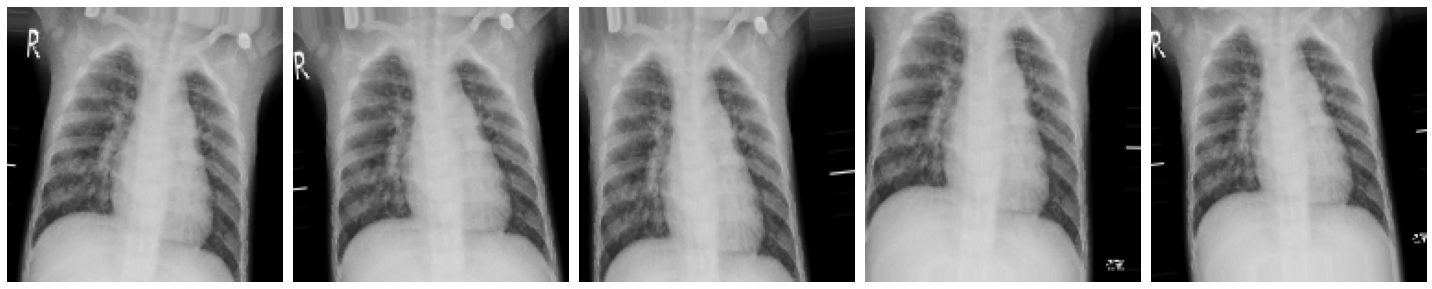

In [19]:
#@title Testing crop position of augmented images at training dataset { display-mode: "form" }

flow_n = 2 #@param {type:"slider", min:2, max:10, step:1}
idx_m = 0 #@param {type:"slider", min:0, max:99, step:1}

# This function will plot augmented images
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show();

plotImages([train_generator[flow_n][0][idx_m] for i in range(5)])

## Design Model

In [20]:
#@title set optimizer and learning_rate{ display-mode: "form" }

optimizer = "RMSprop" #@param ["adam", "RMSprop"]
learning_rate = 0.0008 #@param {type:"number"}

optimizer = Adam(learning_rate=learning_rate) if optimizer == "adam" \
              else RMSprop(learning_rate=learning_rate)

In [23]:
import torch.nn as nn

In [24]:
inputs = Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3))

model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
               input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))(inputs)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Flatten()(model)

model = Dense(activation='relu', units=128)(model)
outputs = Dense(activation='sigmoid', units=1)(model)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

loss = 'binary_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0     

In [25]:
gc.collect()

11973



```
gc.collect()
```
As garbage collector, release memorymemory。


## Train Model

In [ ]:
history = model.fit_generator(
                      train_generator,
                      steps_per_epoch=NB_TRAIN_SAMPLES//BATCH_SIZE+1,
                      epochs=EPOCHS,
                      validation_data=val_generator,
                      validation_steps=NB_VAL_SAMPLES//BATCH_SIZE+1,
                      )

Epoch 1/22
48/48 [==============================] - 188s 4s/step - loss: 0.8055 - accuracy: 0.6595 - val_loss: 0.3957 - val_accuracy: 0.8773
Epoch 2/22
48/48 [==============================] - 182s 4s/step - loss: 0.4123 - accuracy: 0.8269 - val_loss: 0.2738 - val_accuracy: 0.9039
Epoch 3/22
48/48 [==============================] - 200s 4s/step - loss: 0.3028 - accuracy: 0.8777 - val_loss: 0.1971 - val_accuracy: 0.9264
Epoch 4/22
48/48 [==============================] - 175s 4s/step - loss: 0.2517 - accuracy: 0.9013 - val_loss: 0.1404 - val_accuracy: 0.9284
Epoch 5/22
48/48 [==============================] - 175s 4s/step - loss: 0.2386 - accuracy: 0.9055 - val_loss: 0.2259 - val_accuracy: 0.9100
Epoch 6/22
48/48 [==============================] - 174s 4s/step - loss: 0.2144 - accuracy: 0.9176 - val_loss: 0.1467 - val_accuracy: 0.9407
Epoch 7/22
48/48 [==============================] - 172s 4s/step - loss: 0.2059 - accuracy: 0.9220 - val_loss: 0.8150 - val_accuracy: 0.7771
Epoch 8/22
48

In [ ]:
score = model.evaluate(test_generator,
                       step=NB_TEST_SAMPLES//32+1)

## Save model

In [ ]:
# save model
timestamp = datetime.strftime(datetime.now(), "%m%d_%H%m")  #month day hour min
model_fname = f"sequential_{timestamp}"; display(model_fname)
model.save(model_fname, save_format='h5')

log = {}
log['history'] = history.history
log['score'] = {'loss':score[0], 'accuracy':score[1]}
log['params'] = {'epoch':EPOCHS, 'batch_size':BATCH_SIZE,
                 'optimizer':str(optimizer), 'learning_rate': learning_rate, 
                 'loss':loss, 'metrics':str(metrics)}
log_fname = f"log_{timestamp}.json"; display(log_fname)

with open(log_fname, 'w') as f:
  json.dump(log, f)

## Evaluate Model

In [ ]:
import seaborn as sns
sns.set(style='whitegrid')

def plot_metrics(fp, is_url=True):

  if is_url!=True:
    log = json.load(open(fp, 'r'))
  else:
    response = requests.get(fp)
    log = response.json()

  acc = log['history']['accuracy']
  loss = log['history']['loss']
  val_acc = log['history']['val_accuracy']
  val_loss = log['history']['val_loss']

  fig = plt.figure(figsize=(12, 6))

  ax = fig.add_subplot(1,2,1)
  ax.plot(np.arange(1,len(acc)+1), acc, label='train_accuracy')
  ax.plot(np.arange(1,len(val_acc)+1), val_acc, label='val_accuracy')
  ax.legend(loc='lower right')
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epoch #')
  ax.grid()

  ax = fig.add_subplot(1,2,2)
  ax.plot(np.arange(1,len(loss)+1), loss, label='train_loss')
  ax.plot(np.arange(1,len(val_loss)+1), val_loss, label='val_loss')
  ax.legend(loc='upper right')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epoch #')
  ax.yaxis.tick_right()
  ax.yaxis.set_label_position("right")
  ax.grid();

In [ ]:
import seaborn as sns
sns.set(style='whitegrid')

preds = model.predict(test_datagen.flow_from_directory(
                                test_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=32,
                                shuffle=False,
                                class_mode='binary'
                                ),
                      steps=NB_TEST_SAMPLES//32+1)

labels = np.vstack([np.zeros(shape=(NB_TEST_SAMPLES_N,1)),
                    np.ones(shape=(NB_TEST_SAMPLES_P,1))])

# Get the confusion matrix
cm  = tf.math.confusion_matrix(labels.flatten(), np.round(preds).flatten())
ax = sns.heatmap(cm.numpy(), annot=True, fmt="d")